# Sign Recognition Training

## Aims
- To create a LSTM for sign language recognition
- Get decent results of accuracy which are usable within a conversational agent
- Save this LSTM model for local use within the conversational agent
- Test the local model with live openpose data input!

In [0]:
# Hooking up the files in my G Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Just some pytorch imports!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models.video as tvm

# Other general python imports that are needed
import json
import numpy
import os
from collections import Counter
import random
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import string
from sklearn.metrics import confusion_matrix

In [0]:
torch.manual_seed(1)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.backends.cudnn.benchmark=True
!export CUDA_LAUNCH_BLOCKING=1

In [0]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

### Plotting Functions

In [0]:
def please_plot(data, title, num_of_epochs=10, training_loss_range=(0,2), plot_accuracy=True, figsize=(20, 10), bboxes=((1.5, 1), (1.5, 0.5)), epoch_step=1):
    fig, ax1 = plt.subplots(figsize=figsize)
    plt.title(title)

    ax1.set_xlabel("Epoch Number")
    ax1.set_xticks(range(epoch_step, num_of_epochs + 1, epoch_step))

    ax1.set_ylabel("Training Loss")
    ax1.set_ylim(bottom=training_loss_range[0], top=training_loss_range[1])

    if plot_accuracy:
        ax2 = ax1.twinx()
        ax2.set_ylabel("Test Accuracy (%)")
        ax2.set_yticks(range(0, 101, 5))
        ax2.set_ylim(bottom=0, top=100)

    plots = []
    
    for variant, datum in data.items():
        if plot_accuracy:
            plots.append(ax1.plot(range(epoch_step, len(datum[0]) * epoch_step + 1, epoch_step), datum[0], alpha=0.5, marker=".", label="Training Loss"))
            plots.append(ax2.plot(range(epoch_step, len(datum[1]) * epoch_step + 1, epoch_step), datum[1], alpha=0.5, marker="*", label="Test Accuracy", color="G"))
        else:
            plots.append(ax1.plot(range(epoch_step, len(datum) * epoch_step + 1), datum, alpha=0.5, marker=".", label=str(variant)))

    plts = plots[0]

    for i in range(1, len(plots)):
        plts += plots[i]

    ax1.legend(plts, [l.get_label() for l in plts])

    # ax1.legend(bbox_to_anchor=bboxes[0], title="Training Loss Plots")
    # if plot_accuracy:
    #     ax2.legend(bbox_to_anchor=bboxes[1], title="Test Accuracy Plots")

In [0]:
"""Taken and modified from a sklearn doc example"""
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15, 7.5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=sorted(classes), yticklabels=sorted(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# LSTM

## Formatting the Data


In [0]:
# Loading up the json data from the openpose keypoints of the videos

# The path to the training data json openpose keypoint data - /content/gdrive/My\ Drive/Colab\ Notebooks/sign-al/training-data/x.json

training_data_file = open("/content/gdrive/My Drive/Colab Notebooks/sign-al/training-data/max-training-v2.json", "r")
training_data = json.load(training_data_file)
training_data_file.close()

In [0]:
# There is a need to filter the list of data and convert it back to numpy arrays!

for sign, video_data in training_data.items():
    for video_keypoints in video_data:
        for body_part, keypoints in video_keypoints.items():
            video_keypoints[body_part] = torch.tensor(keypoints, device="cuda")

In [0]:
# Changing the data structure of the data to:
#   - combine the body part keypoints
#   - make each frame of keypoints the right size for data input
#   - split it up into training and testing set

training_dataset_percentage = 0.8
testing_dataset_percentage = 0.2

lstm_data = {"training": [], "testing": []}

for sign, video_data in training_data.items():
    
    number_of_training_videos = int(len(video_data) * training_dataset_percentage)

    for video_num, video_keypoints in enumerate(video_data, 1):
        
        all_keypoints = tuple(video_keypoints.values())
        combined_video_body_keypoints = torch.cat(all_keypoints, dim=1).view(-1, 162)

        video_type = "training" if video_num <= number_of_training_videos else "testing"
        lstm_data.get(video_type).append((sign, combined_video_body_keypoints))

random.shuffle(lstm_data["training"])
random.shuffle(lstm_data["testing"])

# print(lstm_data)

In [0]:
print(len(lstm_data["training"]))
print(len(lstm_data["testing"]))

156
52


## Training the LSTM!

## What to do from here!

Seems like that I need to make a proper neural network architecture where I have a final linear layer to get the predictions out of.

Look at https://stackoverflow.com/questions/47952930/how-can-i-use-lstm-in-pytorch-for-classification for a few more details on this

from there I think I will finally be able to learn stuff and predict stuff

everything is a learning curve :) :>

In [0]:
class LSTMClassifier (nn.Module):

    def __init__ (self, num_of_layers=1, hidden_size=108, num_of_classes=26, frame_batch_size=1, state_dict_path=None, dropout=0.2):
        super(LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(162, hidden_size, num_layers=num_of_layers, dropout=dropout).cuda()
        self.linear = nn.Linear(hidden_size, num_of_classes).cuda()
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden = (torch.zeros(num_of_layers, frame_batch_size, hidden_size).cuda(), torch.zeros(num_of_layers, frame_batch_size, hidden_size).cuda())

        if state_dict_path:
            self.load_state_dict(torch.load(state_dict_path))
            self.eval()

    def forward (self, input):
        lstm_output, self.hidden = self.lstm(input, self.hidden)
        linear_output = self.linear(lstm_output[-1])
        probs = self.softmax(linear_output)
        return probs

    def detach_hidden (self):
        self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())

    def zero_hidden (self):
        self.hidden = (torch.zeros_like(self.hidden[0]).cuda(), torch.zeros_like(self.hidden[1]).cuda())
        

## Trying a new train and test function!

In [0]:
"""
returns a trained lstm on the data provided

params:
    - data :: the training and test data to be passed in
    - num_of_epochs :: number of training epochs
    - num_of_layers :: number of layers for the lstm
    - frame_batch_size :: number of frames to take in as batches
    - state_dict_path :: file path to a previous compatible state dictionary of an lstm
"""
def train_and_test_lstm (data, num_of_epochs=1, num_of_layers=1, frame_batch_size=1, state_dict_path=None, result_epoch_step=1):

    # Creating the lstm model
    model = LSTMClassifier(num_of_layers=num_of_layers, frame_batch_size=frame_batch_size, state_dict_path=state_dict_path)

    criterion = nn.NLLLoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    sliding_window_size = 20

    training_loss = []
    testing_accuracy = []

    testing_pred = []
    testing_true = []

    # Training the model
    for epoch in range(1, num_of_epochs + 1):

        print("\nEpoch %d" % (epoch))

        model.train()
        average_epoch_loss = 0.0
        random.shuffle(data["training"])
        for video_num, (sign, video_keypoints) in enumerate(data["training"]):
            training_video_loss = 0.0
            model.detach_hidden()
            # model.zero_hidden()
            # model.zero_grad()

            starting_frame_num = random.randint(0, len(video_keypoints) - 1 - sliding_window_size)

            for frame_num in range(sliding_window_size):
            #for frame_num, frame_keypoint in enumerate(video_keypoints, 1):

                # zero the parameter gradients
                model.zero_grad()
                # optimizer.zero_grad()

                frame_keypoint = video_keypoints[frame_num+starting_frame_num]

                # forward + backward + optimize
                outputs = model(frame_keypoint.view(1,1,-1))

                # print(frame_num+1)

                if (frame_num+1) % sliding_window_size == 0:
                    target = torch.tensor([ord(sign) - 97], dtype=torch.long).cuda()

                    loss = criterion(outputs.view(1,-1), target)
                    loss.backward(retain_graph=True)
                    optimizer.step()

                    # update loss
                    training_video_loss += loss.item()

            #training_video_loss /= len(video_keypoints) // 20
            average_epoch_loss += training_video_loss
            # print("[Epoch %d, Video %d, Sign '%s'] loss: %.3f" % (epoch, video_num, sign, training_video_loss))

        average_epoch_loss /= len(data["training"])
        print("Average Epoch Loss: %.3f" % (average_epoch_loss))

        if epoch % result_epoch_step == 0:
            training_loss.append(average_epoch_loss)

        model.zero_grad()
        model.detach_hidden()
        model.zero_hidden()

        with torch.no_grad():
            model.eval()

            total_videos_correct = 0
            video_total = 0

            random.shuffle(data["testing"])

            for sign, video_keypoints in data["testing"]:

                # model.detach_hidden()
                # model.zero_hidden()
                # model.zero_grad()

                predictions = Counter()

                starting_frame_num = random.randint(0, len(video_keypoints) - 1 - sliding_window_size)
                for frame_num in range(sliding_window_size):
                #for frame_num, frame_keypoint in enumerate(video_keypoints, 1):

                    frame_keypoint = video_keypoints[frame_num+starting_frame_num]

                    outputs = model(frame_keypoint.view(1, 1, -1)).view(1, -1)

                    if (frame_num+1) % sliding_window_size == 0:
                        _, predicted = torch.max(outputs, 1)
                        predicted_char = chr(predicted[0].item() + 97)
                        predictions[predicted_char] += 1

                        if epoch == num_of_epochs:
                            testing_pred.append(predicted_char)
                            testing_true.append(sign)

                # print(predictions)

                # print("Accuracy of frames for '%s' video: %d%%" % (sign, predictions[sign] / len(video_keypoints) * 100))

                if predictions.most_common(1)[0][0] == sign:
                    total_videos_correct += 1
                video_total += 1

            accuracy = total_videos_correct / video_total * 100
            print("Total Accuracy: %d%%" % (accuracy))

            if epoch % result_epoch_step == 0:
                testing_accuracy.append(accuracy)


    return ((training_loss, testing_accuracy), (testing_pred, testing_true))

In [0]:
lstm_base_results = train_and_test_lstm(lstm_data, num_of_layers=2, num_of_epochs=200, result_epoch_step=10)


Epoch 1
Average Epoch Loss: 3.271
Total Accuracy: 3%

Epoch 2
Average Epoch Loss: 3.264
Total Accuracy: 5%

Epoch 3
Average Epoch Loss: 3.250
Total Accuracy: 7%

Epoch 4
Average Epoch Loss: 3.236
Total Accuracy: 7%

Epoch 5
Average Epoch Loss: 3.193
Total Accuracy: 9%

Epoch 6
Average Epoch Loss: 3.108
Total Accuracy: 7%

Epoch 7
Average Epoch Loss: 3.024
Total Accuracy: 11%

Epoch 8
Average Epoch Loss: 2.909
Total Accuracy: 11%

Epoch 9
Average Epoch Loss: 2.837
Total Accuracy: 7%

Epoch 10
Average Epoch Loss: 2.731
Total Accuracy: 11%

Epoch 11
Average Epoch Loss: 2.727
Total Accuracy: 3%

Epoch 12
Average Epoch Loss: 2.699
Total Accuracy: 11%

Epoch 13
Average Epoch Loss: 2.568
Total Accuracy: 7%

Epoch 14
Average Epoch Loss: 2.551
Total Accuracy: 5%

Epoch 15
Average Epoch Loss: 2.553
Total Accuracy: 13%

Epoch 16
Average Epoch Loss: 2.425
Total Accuracy: 13%

Epoch 17
Average Epoch Loss: 2.366
Total Accuracy: 5%

Epoch 18
Average Epoch Loss: 2.380
Total Accuracy: 15%

Epoch 19
Av

## Results of LSTM

In [0]:
print(lstm_base_results)

(([2.731153747349827, 2.2824261366664835, 1.9356132786734033, 1.7560732269464598, 1.5131329096653612, 1.3596417321877217, 1.200189382765118, 1.0230848844802967, 1.0372451923282229, 0.7374925786927609, 0.7822007259619495, 0.6969378627177405, 0.5897539028830087, 0.49528708979629826, 0.5005936606304443, 0.46259685062653905, 0.477244022594424, 0.44856450999920183, 0.4959518112021382, 0.2793896711184893], [11.538461538461538, 9.615384615384617, 9.615384615384617, 9.615384615384617, 7.6923076923076925, 11.538461538461538, 9.615384615384617, 13.461538461538462, 13.461538461538462, 13.461538461538462, 9.615384615384617, 13.461538461538462, 13.461538461538462, 11.538461538461538, 11.538461538461538, 11.538461538461538, 13.461538461538462, 13.461538461538462, 11.538461538461538, 11.538461538461538]), (['e', 't', 'u', 'b', 'u', 'm', 'z', 'l', 'q', 'd', 'u', 'u', 't', 't', 'z', 'c', 'c', 'y', 'x', 'b', 'y', 'y', 'x', 'z', 'd', 's', 'x', 'y', 't', 'z', 'x', 'r', 'l', 't', 'm', 'g', 't', 'd', 'w', '

In [0]:
lstm_base_results = (([2.731153747349827, 2.2824261366664835, 1.9356132786734033, 1.7560732269464598, 1.5131329096653612, 1.3596417321877217, 1.200189382765118, 1.0230848844802967, 1.0372451923282229, 0.7374925786927609, 0.7822007259619495, 0.6969378627177405, 0.5897539028830087, 0.49528708979629826, 0.5005936606304443, 0.46259685062653905, 0.477244022594424, 0.44856450999920183, 0.4959518112021382, 0.2793896711184893], [11.538461538461538, 9.615384615384617, 9.615384615384617, 9.615384615384617, 7.6923076923076925, 11.538461538461538, 9.615384615384617, 13.461538461538462, 13.461538461538462, 13.461538461538462, 9.615384615384617, 13.461538461538462, 13.461538461538462, 11.538461538461538, 11.538461538461538, 11.538461538461538, 13.461538461538462, 13.461538461538462, 11.538461538461538, 11.538461538461538]), (['e', 't', 'u', 'b', 'u', 'm', 'z', 'l', 'q', 'd', 'u', 'u', 't', 't', 'z', 'c', 'c', 'y', 'x', 'b', 'y', 'y', 'x', 'z', 'd', 's', 'x', 'y', 't', 'z', 'x', 'r', 'l', 't', 'm', 'g', 't', 'd', 'w', 's', 'q', 'y', 'v', 'k', 't', 'q', 'v', 'w', 'x', 'q', 'r', 'y'], ['g', 'i', 'o', 'x', 't', 'b', 'u', 'h', 'b', 'p', 'v', 'h', 'r', 'q', 'q', 'c', 'o', 'p', 'e', 'c', 'a', 'k', 'r', 'd', 'm', 'm', 'f', 'y', 'l', 'w', 'e', 't', 'u', 'j', 'w', 'z', 'n', 'd', 's', 'z', 'g', 'l', 'n', 'k', 'f', 'i', 'v', 's', 'x', 'y', 'a', 'j']))

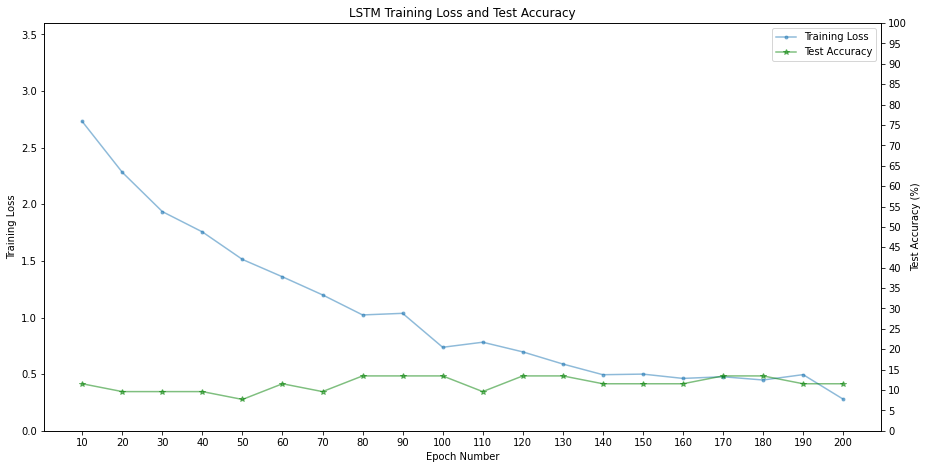

In [0]:
please_plot({"LSTM": lstm_base_results[0]}, "LSTM Training Loss and Test Accuracy", num_of_epochs=200, training_loss_range=(0, 3.6), figsize=(15, 7.5), bboxes=((1.2, 1), (1.2, 0.9)), epoch_step=10)

Confusion matrix, without normalization
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0

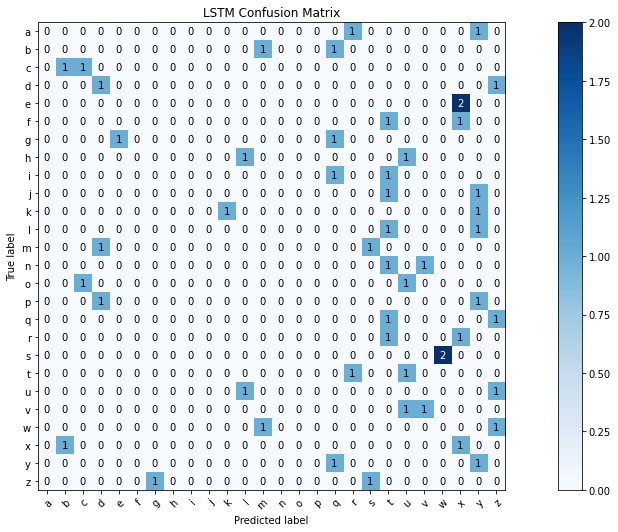

In [0]:
plot_confusion_matrix(lstm_base_results[1][1], lstm_base_results[1][0], list(string.ascii_lowercase), title="LSTM Confusion Matrix")

# Convolutional Sign Recognition Model

### Organising the Data

I am getting the video paths since it would be bad/not possible to load all the videos at once. By organising the video paths into training and testing data sets then I can randomise these safely and have the paths ready for opencv to load for training.

In [0]:
letter_videos_root = "/content/gdrive/My Drive/Colab Notebooks/sign-al/video-training-data/letters/"
training_ratio = 0.8

# (letter, video path)
training_videos = []
testing_videos = []

for letter in os.listdir(letter_videos_root):
    letter_videos = os.listdir(letter_videos_root + letter + '/')
    training_limit = int(len(letter_videos) * 0.8)
    training_videos += [(letter, letter_videos_root + letter + '/' + video) for video in letter_videos[:training_limit]]
    testing_videos += [(letter, letter_videos_root + letter + '/' + video) for video in letter_videos[training_limit:]]

### Testing the sizes of the video frames

I am not sure about resolutions of the videos. Thus I may need to account for this if the videos are not of the correct resolution.

In [0]:
# i =0
# for video in training_videos:
#     # print(video[1])
#     vid = cv2.VideoCapture(video[1])
#     read, frame = vid.read()
#     frame = cv2.resize(frame, (128, 128))
#     print(frame.shape)
#     break


### The Convolutional Architecture



Since I am unsure about quite a few things about current architectures like resnet that work better I think that I will currently just work on my own new simple architecture and explore the parameters.

In [0]:
# Network that takes in x frames of 128x128 RGB Video
class SignConvNet (nn.Module):
    
    def __init__ (self, sliding_window_size=20, activate_fn=F.relu, pooling_fn=F.max_pool3d, dropout=0.0):
        super(SignConvNet, self).__init__()

        # Initial input has 3 colour channels

        # Sliding Window Size
        self.sliding_window_size = sliding_window_size

        # Activation Function
        self.activate_fn = activate_fn

        # Dropout probability
        self.dropout = dropout

        # Pooling Function
        self.pooling_fn = pooling_fn
        self.pooling_stride = (2, 2, 2) # every 2 frames, every 2 horizontal pixels, every 2 vertical pixels
        self.pixel_pooling_stride = (1, 2, 2) # every frame, every 2 horizontal pixels, every 2 vertical pixels

        # Conv Layer 1 :: SlidingWindowSizex128x128x3 -> SlidingWindowSizex128x128x6
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        # After pooling :: (SlidingWindowSize/2)x64x64x6

        # Conv Layer 2 :: (SlidingWindowSize/2)x64x64x6 -> (SlidingWindowSize/2)x64x64x12
        self.conv2 = nn.Conv3d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        # After pooling :: (SlidingWindowSize/2*2)x32x32x12

        # Conv Layer 3 :: (SlidingWindowSize/2*2)x32x32x12 -> (SlidingWindowSize/2*2)x32x32x24
        self.conv3 = nn.Conv3d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
        # After pooling :: (SlidingWindowSize/2*2)x16x16x24

        # Linear Layers
        self.fc1 = nn.Linear(30720, 2000)
        self.fc2 = nn.Linear(2000, 100)
        self.fc3 = nn.Linear(100, 26)

    # With the network in this form the input should be of shape (1, 3, 20, 128, 128)
    def forward (self, input):
        # Conv Layers
        x = self.conv1(input)
        x = F.dropout3d(x, p=self.dropout)
        x = self.activate_fn(x)
        x = self.pooling_fn(x, self.pooling_stride)

        x = self.conv2(x)
        x = F.dropout3d(x, p=self.dropout)
        x = self.activate_fn(x)
        x = self.pooling_fn(x, self.pooling_stride)

        x = self.conv3(x)
        x = F.dropout3d(x, p=self.dropout)
        x = self.activate_fn(x)
        x = self.pooling_fn(x, self.pixel_pooling_stride)

        # Changing the size so that it can be used for the linear layers
        x = x.view(-1, 24 * 16 * 16 * 5)

        # Linear Layers
        x = self.fc1(x)
        x = F.dropout(x, p=self.dropout)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout)
        x = self.activate_fn(x)
        
        x = self.fc3(x)

        return x


### The Conv Net Training Function

In [0]:
""" 
    Returns a random chunks of the videos of the size of the sliding window provided. 
    Will return the video in a new shape of (RGB Channels, Sliding Window Size, 112, 112)
    Returns None if the sliding window size is bigger than the number of frames in the video.

    If for_resnet is True then the images will be put into a range of [0, 1] and normalised.
"""
def getRandomSlidingWindows (video_paths, sliding_window_size, resolution=(112, 112), for_resnet=True):
    data = torch.empty((len(video_paths), 3, sliding_window_size, resolution[0], resolution[1])).double().cuda()

    # Process Each Video
    for index, video_path in enumerate(video_paths):
        video = cv2.VideoCapture(video_path)
        frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        if frame_count < sliding_window_size:
            return None

        # Finds a random frame starting position to get a sliding window from
        starting_frame_num = random.randint(0, frame_count - 1 - sliding_window_size)
        video.set(cv2.CAP_PROP_POS_FRAMES, starting_frame_num)

        frames = []

        # Process the video into a stack of RGB frames
        for i in range(sliding_window_size):
            read, frame = video.read()
            frames.append(cv2.resize(frame, resolution))
            
        frames = numpy.stack(frames)
        # change the order of the dimensions so that colour is the first dimension, then frames and then width and height of the frame
        frames = numpy.einsum("fwhc->cfwh", frames)
        frames = torch.from_numpy(frames).double()

        if for_resnet:
            frames = frames / 255
            shape = (-1,) + (1,) * (frames.dim() - 1)
            mean = [0.43216, 0.394666, 0.37645]
            mean = torch.as_tensor(mean).reshape(shape)
            std = [0.22803, 0.22145, 0.216989]
            std = torch.as_tensor(std).reshape(shape)
            frames = (frames - mean) / std

        data[index] = frames.cuda()

    return data

In [0]:
def train (model, data, batch_size, sliding_window_size, criterion, optimiser):
    model.train()

    random.shuffle(data)

    running_loss = 0

    for batch_num, chunk_start_index in enumerate(range(0, len(data), batch_size), 1):
        data_chunk = data[chunk_start_index:] if chunk_start_index + batch_size > len(data) else data[chunk_start_index : chunk_start_index + batch_size]

        signs, video_paths = zip(*data_chunk)

        input_frames = getRandomSlidingWindows(video_paths, sliding_window_size)
        target = torch.tensor([ord(sign) - 97 for sign in signs], dtype=torch.long).cuda()

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
        output = model(input_frames)
        loss = criterion(output, target)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        print("%03d :: %.3f" % (batch_num, loss))

    average_loss = running_loss / int(len(data) / batch_size + 1)

    print("\nEpoch Average Loss :: %.3f\n\n" % (average_loss))

    return average_loss

### The Conv Net Test Function

In [0]:
def test (model, data, sliding_window_size):
    model.eval()

    random.shuffle(data)

    correct = 0
    pred_signs = []
    true_signs = []

    print("Video Num :: Actual :: Predicted :: Top 5 Predicted\n")

    with torch.no_grad():
        for video_num, (sign, video_path) in enumerate(data, 1):
            input_frames = getRandomSlidingWindows([video_path], sliding_window_size)

            output = model(input_frames)

            _, predicted = torch.max(output, 1)
            _, top_predicted = torch.topk(output, 5, 1)

            prediction = chr(predicted.item() + 97)
            top_predictions = [chr(x.item() + 97) for x in top_predicted.squeeze()]

            pred_signs.append(prediction)
            true_signs.append(sign)

            if prediction == sign:
                correct += 1

            print("%02d :: %s :: %s ::" % (video_num, sign, prediction), top_predictions)

    accuracy = correct / len(data) * 100

    print("\nAccuracy :: %d%%" % (accuracy))

    return (accuracy, pred_signs, true_signs)

### Conv Net Trial Function

This function will be used to try out different parameters and such but also to run many epochs of training on the model.

In [0]:
def trial (model, training_data, test_data, num_of_epochs=10, batch_size=26, sliding_window_size=20, learning_rate=0.001, momentum=0.9):
    criterion = nn.CrossEntropyLoss(ignore_index=-1).cuda()
    optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    training_losses = []
    test_accuracies = []

    for epoch_num in range(1, num_of_epochs + 1):
        print("\n\nEPOCH %d\n" % (epoch_num))
        training_losses.append(train(model, training_data, batch_size, sliding_window_size, criterion, optimiser))
        test_accuracies.append(test(model, test_data, sliding_window_size)[0])

    return (training_losses, test_accuracies)

### Trying to Find the Best Parameters for the Net

In [0]:
learning_rates = [0.001, 0.0001, 0.00001]
momentums = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
dropout_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
activation_fns = [("relu", F.relu), ("lrelu", F.leaky_relu), ("softmax", F.softmax), ("tanh", F.tanh), ("sig", F.sigmoid)]
pooling_fns = [("max", F.max_pool3d), ("avg", F.avg_pool3d)]

In [0]:
def explore_parameters ():
    param_exploration_results = {}

    for lr in learning_rates:
        for m in momentums:
            for d in dropout_probs:
                for an, a in activation_fns:
                    for pn, p in pooling_fns:
                        trial_name = "%.5f-%.2f-%.1f-%s-%s" % (lr, m, d, an, pn)

                        print("\n\n\n%s\n\n\n" % (trial_name))

                        param_exploration_results[trial_name] = trial(
                            training_videos, 
                            testing_videos, 
                            learning_rate=lr, 
                            momentum=m, 
                            dropout=d, 
                            activate_fn=a,
                            pooling_fn=p
                        )

    return param_exploration_results

Since the exploration is taking too long I am going to explore the parameters independently.

In [0]:
def explore_lrs ():
    results = {}

    for lr in learning_rates:
        results[lr] = trial(
            training_videos,
            testing_videos,
            learning_rate=lr
        )
    
    return results
        

In [0]:
lr_exploration = explore_lrs()

In [0]:
print(lr_exploration)

please_plot(lr_exploration, "Learning Rates Loss and Accuracy", training_loss_range=(0, 4))

I decided after weak results to try using a 3D ResNet.

### Resnet Trial

I stopped the resnet after not learning anything from 5 epochs. Looks like it may be overfitting.

I'm going to try to get a pretrained network to see what happens. And then I'll try to change learning rate to prevent overfitting.

Never Mind, Looks Like I'll need to make a class that goes from the final layer to the 26 classes if I want to do pretrained.

In [0]:
class ResNet (nn.Module):

    def __init__ (self):
        super(ResNet, self).__init__()
        self.resnet = tvm.r2plus1d_18(pretrained=True)
        self.linear = nn.Linear(400, 26)

    def forward (self, x):
        x = self.resnet(x)
        x = F.relu(x)
        x = self.linear(x)
        return x


#### Finding a Learning Rate Trials

In [0]:
model = ResNet().cuda()

In [0]:
trial(model, training_videos, testing_videos, num_of_epochs=5, batch_size=4)

Now Trying Different Learning Rates

In [0]:
trial(ResNet().cuda(), training_videos, testing_videos, num_of_epochs=5, batch_size=4, learning_rate=0.0001)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:02<00:00, 57.8MB/s]




EPOCH 1

001 :: 3.528
002 :: 3.407
003 :: 4.027
004 :: 3.189
005 :: 3.713
006 :: 3.262
007 :: 3.553
008 :: 3.599
009 :: 3.423
010 :: 3.548
011 :: 4.412
012 :: 3.836
013 :: 3.383
014 :: 3.194
015 :: 3.337
016 :: 3.981
017 :: 3.315
018 :: 3.249
019 :: 3.242
020 :: 3.059
021 :: 3.580
022 :: 3.338
023 :: 3.491
024 :: 3.316
025 :: 3.437
026 :: 3.530
027 :: 3.462
028 :: 3.068
029 :: 3.783
030 :: 3.288
031 :: 3.303
032 :: 3.626
033 :: 3.022
034 :: 3.563
035 :: 3.152
036 :: 3.210
037 :: 3.215
038 :: 3.506
039 :: 3.177

Epoch Average Loss :: 3.358


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: i :: n :: ['n', 'v', 'e', 'z', 'r']
02 :: i :: t :: ['t', 'v', 'p', 'g', 'a']
03 :: z :: v :: ['v', 'e', 'g', 'h', 't']
04 :: q :: n :: ['n', 'e', 'g', 'r', 'v']
05 :: f :: e :: ['e', 't', 'z', 'r', 'n']
06 :: l :: e :: ['e', 'n', 'i', 'v', 'j']
07 :: n :: b :: ['b', 'n', 'm', 'a', 'g']
08 :: h :: g :: ['g', 'v', 's', 't', 'h']
09 :: h :: n :: ['n', 's', 'o', 'm', 'f']
10 :: a :: j :: ['j'

([3.3580761671595774,
  3.19873531646271,
  3.1352908737773664,
  3.0727321050502554,
  2.940627090723018],
 [1.9230769230769231,
  3.8461538461538463,
  5.769230769230769,
  3.8461538461538463,
  3.8461538461538463])

The accuracy still isn't gradually increasing but the loss is gradually decreasing.

In [0]:
results = trial(ResNet().cuda(), training_videos, testing_videos, num_of_epochs=5, batch_size=4, learning_rate=0.00001)



EPOCH 1

001 :: 3.656
002 :: 3.684
003 :: 3.515
004 :: 3.827
005 :: 3.425
006 :: 3.686
007 :: 3.463
008 :: 2.828
009 :: 3.880
010 :: 3.842
011 :: 3.473
012 :: 3.484
013 :: 3.442
014 :: 3.200
015 :: 3.180
016 :: 3.143
017 :: 3.476
018 :: 3.805
019 :: 3.351
020 :: 3.905
021 :: 3.155
022 :: 3.719
023 :: 3.384
024 :: 3.528
025 :: 3.114
026 :: 3.490
027 :: 3.738
028 :: 3.694
029 :: 3.611
030 :: 3.295
031 :: 3.587
032 :: 3.758
033 :: 3.101
034 :: 3.600
035 :: 3.150
036 :: 3.269
037 :: 3.480
038 :: 3.619
039 :: 3.311

Epoch Average Loss :: 3.397


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: f :: f :: ['f', 'z', 'h', 'b', 'c']
02 :: q :: b :: ['b', 'c', 'h', 'a', 'l']
03 :: h :: f :: ['f', 't', 'h', 'c', 'a']
04 :: k :: l :: ['l', 'c', 'f', 'z', 'h']
05 :: e :: f :: ['f', 'c', 'a', 'k', 'z']
06 :: j :: z :: ['z', 'y', 'b', 'l', 'h']
07 :: t :: f :: ['f', 'c', 't', 'a', 'k']
08 :: o :: f :: ['f', 'h', 'l', 'g', 'c']
09 :: a :: c :: ['c', 'f', 'a', 'k', 'b']
10 :: k :: f :: ['f'

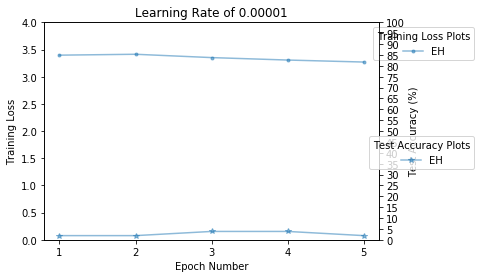

In [0]:
please_plot({"EH": results}, "Learning Rate of 0.00001", training_loss_range=(0, 4))

In [0]:
results = trial(ResNet().cuda(), training_videos, testing_videos, num_of_epochs=5, batch_size=4, learning_rate=0.00005)



EPOCH 1

001 :: 3.592
002 :: 3.491
003 :: 3.499
004 :: 3.767
005 :: 3.373
006 :: 3.666
007 :: 2.687
008 :: 3.634
009 :: 3.876
010 :: 2.607
011 :: 2.804
012 :: 3.343
013 :: 3.458
014 :: 3.198
015 :: 3.731
016 :: 4.031
017 :: 3.063
018 :: 3.755
019 :: 3.882
020 :: 3.435
021 :: 3.486
022 :: 3.676
023 :: 3.611
024 :: 3.467
025 :: 2.943
026 :: 3.616
027 :: 3.523
028 :: 3.514
029 :: 3.414
030 :: 3.604
031 :: 3.569
032 :: 3.665
033 :: 3.540
034 :: 3.050
035 :: 3.411
036 :: 3.339
037 :: 3.253
038 :: 3.406
039 :: 3.652

Epoch Average Loss :: 3.366


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: z :: o :: ['o', 'k', 'q', 'r', 'u']
02 :: b :: c :: ['c', 'o', 'k', 'q', 'z']
03 :: e :: q :: ['q', 'o', 'u', 'g', 'y']
04 :: n :: o :: ['o', 'k', 'c', 'q', 'u']
05 :: i :: k :: ['k', 'o', 'c', 'u', 'q']
06 :: s :: g :: ['g', 'l', 'q', 'r', 'a']
07 :: j :: w :: ['w', 'a', 't', 'z', 'g']
08 :: x :: o :: ['o', 'g', 'r', 'q', 't']
09 :: t :: q :: ['q', 'c', 'o', 'g', 'k']
10 :: r :: o :: ['o'

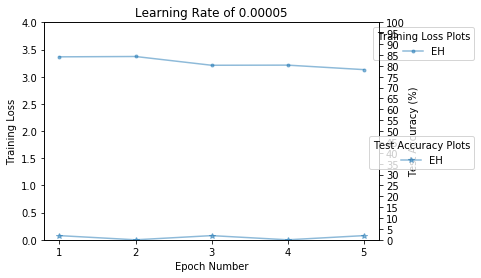

In [0]:
# please_plot({"EH": results}, "Learning Rate of 0.00005", training_loss_range=(0, 4))

In [0]:
results = trial(ResNet().cuda(), training_videos, testing_videos, num_of_epochs=5, batch_size=4, learning_rate=0.0005)



EPOCH 1

001 :: 3.048
002 :: 3.512
003 :: 3.746
004 :: 3.557
005 :: 3.865
006 :: 3.366
007 :: 3.724
008 :: 2.681
009 :: 3.678
010 :: 3.301
011 :: 3.678
012 :: 3.750
013 :: 3.691
014 :: 3.480
015 :: 3.541
016 :: 3.834
017 :: 3.486
018 :: 4.244
019 :: 3.910
020 :: 3.397
021 :: 3.737
022 :: 3.056
023 :: 3.813
024 :: 3.810
025 :: 3.436
026 :: 3.601
027 :: 4.155
028 :: 3.232
029 :: 2.936
030 :: 3.680
031 :: 3.084
032 :: 3.835
033 :: 3.909
034 :: 3.685
035 :: 3.859
036 :: 3.215
037 :: 3.504
038 :: 3.513
039 :: 3.953

Epoch Average Loss :: 3.487


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: v :: v :: ['v', 'd', 'g', 'l', 'z']
02 :: j :: l :: ['l', 'h', 's', 'g', 'q']
03 :: t :: d :: ['d', 'q', 'g', 'v', 'c']
04 :: a :: q :: ['q', 'j', 'd', 'f', 'l']
05 :: r :: g :: ['g', 'r', 'd', 'q', 'l']
06 :: s :: f :: ['f', 'd', 'j', 'e', 'z']
07 :: c :: v :: ['v', 'd', 's', 'g', 'z']
08 :: a :: v :: ['v', 'd', 'z', 's', 'p']
09 :: u :: q :: ['q', 'g', 'd', 'c', 'y']
10 :: z :: v :: ['v'

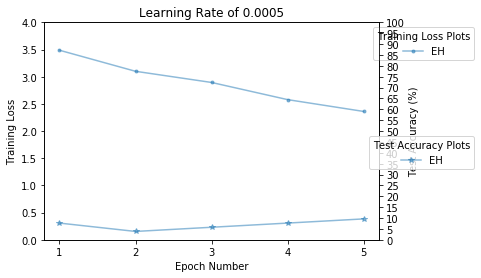

In [0]:
please_plot({"EH": results}, "Learning Rate of 0.0005", training_loss_range=(0, 4))

#### Best Learning Rate Trial

The above results were somewhat promising so I might let it continue training for a bit.

In [0]:
model = ResNet().cuda()
results = trial(model, training_videos, testing_videos, num_of_epochs=20, batch_size=4, learning_rate=0.0005)



EPOCH 1

001 :: 3.807
002 :: 3.489
003 :: 3.594
004 :: 3.575
005 :: 3.862
006 :: 4.042
007 :: 3.053
008 :: 3.728
009 :: 3.535
010 :: 3.455
011 :: 3.726
012 :: 3.106
013 :: 3.592
014 :: 3.798
015 :: 3.653
016 :: 3.561
017 :: 3.200
018 :: 3.918
019 :: 3.326
020 :: 3.417
021 :: 3.515
022 :: 3.314
023 :: 3.893
024 :: 3.386
025 :: 3.333
026 :: 3.874
027 :: 3.993
028 :: 3.453
029 :: 3.305
030 :: 3.082
031 :: 4.210
032 :: 3.407
033 :: 3.341
034 :: 3.732
035 :: 3.559
036 :: 3.698
037 :: 3.234
038 :: 3.252
039 :: 3.857

Epoch Average Loss :: 3.472


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: f :: v :: ['v', 'd', 'x', 'n', 't']
02 :: d :: r :: ['r', 'e', 'm', 'v', 'i']
03 :: c :: e :: ['e', 'h', 'u', 't', 'b']
04 :: v :: t :: ['t', 'j', 's', 'z', 'g']
05 :: h :: h :: ['h', 't', 'p', 'f', 'z']
06 :: i :: r :: ['r', 'v', 'e', 'j', 'a']
07 :: k :: r :: ['r', 'v', 'j', 't', 'i']
08 :: v :: v :: ['v', 'j', 't', 'r', 'z']
09 :: x :: f :: ['f', 'd', 'z', 'p', 'j']
10 :: r :: t :: ['t'

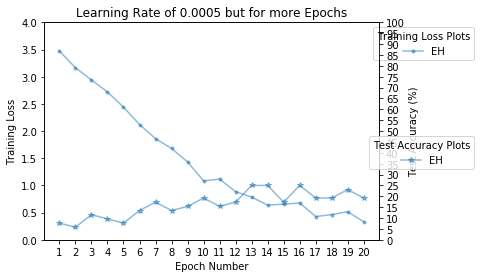

In [0]:
please_plot({"EH": results}, "Learning Rate of 0.0005 but for more Epochs", training_loss_range=(0, 4), num_of_epochs=20)

In [0]:
model = ResNet().cuda()
results = trial(model, training_videos, testing_videos, num_of_epochs=20, batch_size=4, learning_rate=0.0005)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/checkpoints/r2plus1d_18-91a641e6.pth





EPOCH 1

001 :: 3.601
002 :: 3.249
003 :: 3.837
004 :: 3.737
005 :: 3.366
006 :: 3.205
007 :: 3.470
008 :: 3.046
009 :: 3.127
010 :: 3.498
011 :: 3.520
012 :: 4.189
013 :: 3.370
014 :: 3.868
015 :: 3.542
016 :: 3.556
017 :: 3.608
018 :: 3.627
019 :: 3.600
020 :: 3.027
021 :: 3.445
022 :: 3.740
023 :: 3.882
024 :: 3.322
025 :: 4.048
026 :: 2.960
027 :: 3.386
028 :: 3.743
029 :: 3.931
030 :: 3.841
031 :: 3.218
032 :: 4.298
033 :: 3.596
034 :: 3.375
035 :: 3.395
036 :: 4.133
037 :: 3.350
038 :: 3.876
039 :: 3.352

Epoch Average Loss :: 3.473


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: q :: p :: ['p', 't', 'v', 'b', 'g']
02 :: i :: t :: ['t', 'v', 'p', 'z', 's']
03 :: g :: t :: ['t', 'p', 'v', 'b', 'z']
04 :: w :: w :: ['w', 'i', 'q', 'g', 'n']
05 :: w :: p :: ['p', 't', 'c', 'g', 's']
06 :: y :: s :: ['s', 'i', 'r', 'd', 'h']
07 :: g :: s :: ['s', 'd', 'f', 'z', 'i']
08 :: h :: p :: ['p', 't', 's', 'v', 'a']
09 :: x :: z :: ['z', 'p', 'e', 't', 'v']
10 :: z :: v :: ['v

In [0]:
print(results)

([3.4732767789128203, 3.1743157340591788, 2.9284358278338933, 2.7415126596822637, 2.2932639240918453, 2.1688142373494115, 1.9031166215125292, 1.5298346488164474, 1.3657034688842882, 1.4212192129675483, 1.0728838108559446, 1.0087552238613053, 0.6954838475048083, 0.767728832753014, 0.5670977358523664, 0.6329755276640514, 0.46077751915645254, 0.43292162360522185, 0.32739036245653813, 0.2996803750981457], [7.6923076923076925, 5.769230769230769, 7.6923076923076925, 9.615384615384617, 13.461538461538462, 13.461538461538462, 17.307692307692307, 11.538461538461538, 17.307692307692307, 21.153846153846153, 21.153846153846153, 11.538461538461538, 26.923076923076923, 23.076923076923077, 21.153846153846153, 17.307692307692307, 19.230769230769234, 28.846153846153843, 21.153846153846153, 28.846153846153843])


In [0]:
results = ([3.4732767789128203, 3.1743157340591788, 2.9284358278338933, 2.7415126596822637, 2.2932639240918453, 2.1688142373494115, 1.9031166215125292, 1.5298346488164474, 1.3657034688842882, 1.4212192129675483, 1.0728838108559446, 1.0087552238613053, 0.6954838475048083, 0.767728832753014, 0.5670977358523664, 0.6329755276640514, 0.46077751915645254, 0.43292162360522185, 0.32739036245653813, 0.2996803750981457], [7.6923076923076925, 5.769230769230769, 7.6923076923076925, 9.615384615384617, 13.461538461538462, 13.461538461538462, 17.307692307692307, 11.538461538461538, 17.307692307692307, 21.153846153846153, 21.153846153846153, 11.538461538461538, 26.923076923076923, 23.076923076923077, 21.153846153846153, 17.307692307692307, 19.230769230769234, 28.846153846153843, 21.153846153846153, 28.846153846153843])


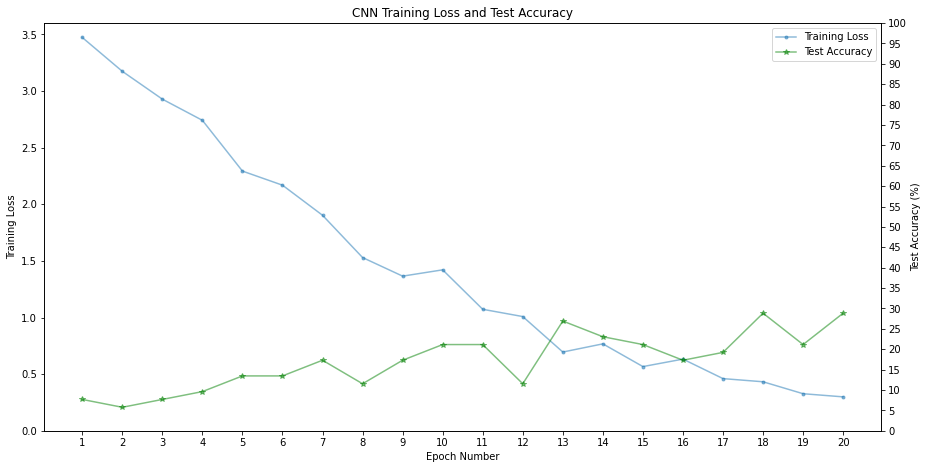

In [0]:
please_plot({"ResNet (2+1)D": results}, "CNN Training Loss and Test Accuracy", num_of_epochs=20, training_loss_range=(0,3.6), figsize=(15, 7.5), bboxes=((1.2, 1), (1.2, 0.9)))

In [0]:
resnet_test_results = test(model, testing_videos, 20)

Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: y :: l :: ['l', 'z', 't', 'u', 'p']
02 :: x :: k :: ['k', 'x', 'e', 'i', 's']
03 :: s :: h :: ['h', 's', 'g', 'r', 'z']
04 :: g :: g :: ['g', 'i', 'h', 's', 'w']
05 :: h :: h :: ['h', 's', 'j', 'e', 'f']
06 :: l :: l :: ['l', 'i', 'a', 'm', 't']
07 :: i :: t :: ['t', 'e', 'x', 's', 'a']
08 :: d :: d :: ['d', 'h', 'w', 'i', 'b']
09 :: v :: t :: ['t', 'a', 'z', 'i', 'm']
10 :: o :: h :: ['h', 'i', 'j', 'g', 'o']
11 :: h :: h :: ['h', 'j', 's', 'f', 'b']
12 :: l :: t :: ['t', 'e', 'a', 's', 'j']
13 :: v :: j :: ['j', 'y', 'h', 'l', 'a']
14 :: b :: b :: ['b', 'c', 'h', 'j', 'f']
15 :: t :: t :: ['t', 'a', 's', 'j', 'h']
16 :: f :: i :: ['i', 'e', 'd', 'z', 'g']
17 :: b :: d :: ['d', 'p', 'i', 'u', 'w']
18 :: t :: t :: ['t', 'a', 'm', 'j', 's']
19 :: u :: t :: ['t', 'a', 'z', 'e', 'g']
20 :: n :: j :: ['j', 'a', 'h', 'm', 'g']
21 :: g :: g :: ['g', 'w', 'h', 'r', 'j']
22 :: n :: i :: ['i', 'g', 'u', 'j', 'z']
23 :: k :: e :: ['e', '

In [0]:
print(resnet_test_results)

(30.76923076923077, ['l', 'k', 'h', 'g', 'h', 'l', 't', 'd', 't', 'h', 'h', 't', 'j', 'b', 't', 'i', 'd', 't', 't', 'j', 'g', 'i', 'e', 'j', 'j', 't', 'i', 'c', 'f', 't', 'z', 't', 'd', 'a', 'g', 'd', 'a', 'j', 'g', 'd', 'c', 'r', 'i', 'a', 't', 'z', 'u', 'k', 'i', 'j', 'z', 'i'], ['y', 'x', 's', 'g', 'h', 'l', 'i', 'd', 'v', 'o', 'h', 'l', 'v', 'b', 't', 'f', 'b', 't', 'u', 'n', 'g', 'n', 'k', 'u', 'j', 'q', 's', 'c', 'k', 'f', 'd', 'q', 'p', 'e', 'm', 'p', 'a', 'z', 'w', 'x', 'c', 'y', 'm', 'a', 'j', 'r', 'o', 'e', 'i', 'r', 'z', 'w'])


Confusion matrix, without normalization
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0

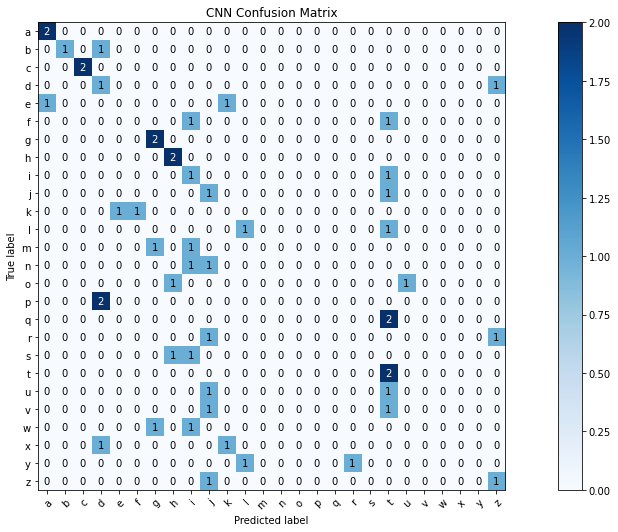

In [0]:
plot_confusion_matrix(resnet_test_results[2], resnet_test_results[1], list(string.ascii_lowercase), title="CNN Confusion Matrix")

In [0]:
model = ResNet().cuda()
results = trial(model, training_videos, testing_videos, num_of_epochs=50, batch_size=4, learning_rate=0.0005)



EPOCH 1

001 :: 3.434
002 :: 3.385
003 :: 3.461
004 :: 3.254
005 :: 3.418
006 :: 3.539
007 :: 3.352
008 :: 3.449
009 :: 3.161
010 :: 3.795
011 :: 3.737
012 :: 3.426
013 :: 3.498
014 :: 3.446
015 :: 3.237
016 :: 3.964
017 :: 2.811
018 :: 3.371
019 :: 3.460
020 :: 3.320
021 :: 3.447
022 :: 3.853
023 :: 3.834
024 :: 3.441
025 :: 3.521
026 :: 3.371
027 :: 3.537
028 :: 3.367
029 :: 3.663
030 :: 3.337
031 :: 3.354
032 :: 3.689
033 :: 4.081
034 :: 3.788
035 :: 3.727
036 :: 3.371
037 :: 3.562
038 :: 3.849
039 :: 3.609

Epoch Average Loss :: 3.423


Video Num :: Actual :: Predicted :: Top 5 Predicted

01 :: x :: j :: ['j', 'q', 'g', 'f', 'v']
02 :: z :: z :: ['z', 'e', 'j', 'i', 'g']
03 :: b :: q :: ['q', 'z', 'k', 'b', 'a']
04 :: e :: b :: ['b', 'j', 'k', 's', 'q']
05 :: j :: e :: ['e', 't', 'x', 'k', 'w']
06 :: p :: z :: ['z', 'q', 'j', 'v', 'b']
07 :: r :: f :: ['f', 'a', 'e', 'v', 'g']
08 :: b :: g :: ['g', 'a', 'v', 't', 'u']
09 :: y :: v :: ['v', 'z', 'g', 'p', 't']
10 :: h :: x :: ['x'